In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils

import h5py
import numpy as np
from tensorflow.keras import utils
import numpy as np
from sklearn.model_selection import train_test_split

# To get the images and labels from file

with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
print("Done")
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1)
print("Done")
X_train, y_train, X_test, y_test = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]
print("Done")

# # building the input vector from the 32x32 pixels
X_train = X_train.reshape(X_train.shape[0], 256, 256, 3)
X_test = X_test.reshape(X_test.shape[0], 256, 256, 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training




Done
Done
Done


In [2]:
%matplotlib notebook

In [3]:
#X_train = X_train.reshape(len(X_train), -1).astype(np.float32)
#X_test = X_test.reshape(len(X_test), -1).astype(np.float32)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

mean_image = X_train.mean(axis=0)
std_image = X_train.std(axis=0)

X_train -= mean_image
X_train /= std_image

X_test -= mean_image
X_test /= std_image


In [4]:
X_train = X_train.reshape(15962, 3, 256, 256)
X_test = X_test.reshape(1774, 3, 256, 256)

In [5]:
import mygrad as mg
import torch
from torch import tensor
import torch.nn as nn
relu = nn.functional.relu
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(59536, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def accuracy(predictions, truth):
    """
    Returns the mean classification accuracy for a batch of predictions.
    
    Parameters
    ----------
    predictions : Union[numpy.ndarray, mg.Tensor], shape=(M, D)
        The scores for D classes, for a batch of M data points
    truth : numpy.ndarray, shape=(M,)
        The true labels for each datum in the batch: each label is an
        integer in [0, D)
    
    Returns
    -------
    float
    """
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean((torch.argmax(prediction, dim=1) == truth).cpu().numpy())


In [6]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data = torch.tensor(X_train).to(device)
test_data = torch.tensor(y_train, dtype=torch.int64).to(device)

X = torch.tensor(X_test).to(device)
Y = torch.tensor(y_test, dtype=torch.int64).to(device)



<IPython.core.display.Javascript object>


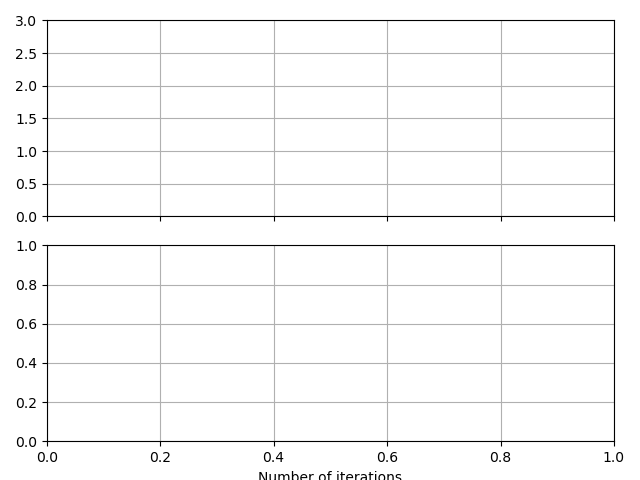

cpu


In [7]:
from noggin import create_plot
 
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])

ax[0].set_ylim(0, 3)
batch_size = 100
print(device)

In [36]:
model =  Model().to(device)

# initialize the optimizer
optim = torch.optim.Adam(model.parameters(), weight_decay=5E-3)

In [41]:
for epoch_cnt in range(10):
    idxs = np.arange(len(X_train))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)  
    
    for batch_cnt in range(0, len(X_train)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = train_data[batch_indices]  # random batch of our training data

        prediction = model(batch)
       
        truth = test_data[batch_indices]
       
        # Although its name does not indicate this, the `cross_entropy` loss
        # here also *includes a softmax* before computing the actual cross-entropy.
        loss = nn.functional.cross_entropy(prediction, truth)
        acc = accuracy(prediction, truth)
        loss.backward()
        
        optim.step()
        
        # Unlike in MyGrad, after you perform a gradient-based step with your optimizer, you
        # must explicitly delete/zero-out the gradients of your model's parameters
        # once you are done with them. MyGrad handles this for us, but PyTorch does not.
        optim.zero_grad()  
        
        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size, plot=True)
    
    # This context manager simply signals to pytorch that we will not be 
    # computing any gradients (since we are only evaluating our model on
    # test data, not training on it). This will allow PyTorch to optimize
    # its computation
    with torch.autograd.no_grad():
        for batch_cnt in range(0, len(X_test)//batch_size):
            idxs = np.arange(len(X_test))
            batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
            batch = X[batch_indices] 
            prediction = model(batch)
            truth = Y[batch_indices]
            acc = accuracy(prediction, truth)
            plotter.set_test_batch({ "accuracy" : acc},
                                     batch_size=batch_size)
    plotter.set_train_epoch()
    plotter.set_test_epoch()  

KeyboardInterrupt: 